In [2]:
# Als je `import clusterizer` typt, dan zoekt Python naar mappen en .py-bestanden met die naam.
# De plekken waar python gaat zoeken staan in de lijst `sys.path`.
# Omdat we nu in SCG-analyse/notebooks zitten, moeten we de bovenliggende map (`SCG-analyse`)
# toevoegen aan de lijst van zoekplekken.

# Als de module is "geinstalleerd" is dit niet nodig.
import sys
if ".." not in sys.path:
    sys.path.append("..")

# Hiermee wordt de clusterizer-module herladen wanneer een bestand ervan verandert
# (handig als je aan de module aan het werken bent).
# Als je dit niet doet, wordt de code (zoals circuit.py, plot.py, etc) alleen geladen wanneer
# je `import clusterizer` typt.
%load_ext autoreload
%autoreload 2

#      👇👇👇👇👇

import clusterizer

#      👆👆👆👆👆

import matplotlib.pyplot as plt
# Nodig om een np.datetime64 tijdstip (zoals in de partial_discharges DataFrame) 
# als ascoordinaat te gebruiken.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Hogere DPI voor plotjes
%config InlineBackend.figure_format = 'retina'
# Standaard grootte van plotjes, in inches
plt.rcParams['figure.figsize'] = [8, 5]

import pandas as pd
import numpy as np

Git root path found at: C:\dev\py\SCG-analyse
Using data path:        C:\dev\py\SCG-analyse\data\origineel


# Eerste submodule: `clusterizer.globals`
_In principe een kopie van de `globals.py` die we hebben gekregen, maar met extra's._

Hierin staan maar twee interessante dingen:

De map waarin wordt gezocht naar `.csv`-bestanden. (Wordt automatisch gevonden.)

In [3]:
clusterizer.globals.datadir

WindowsPath('C:/dev/py/SCG-analyse/data/origineel')

Lijst met circuitnummers waarvan de partial discharges zijn gegeven.

In [4]:
clusterizer.globals.available_circuits

[2145, 3010, 2979, 2980, 1512, 2063, 2870, 2806, 99999999]

# Tweede submodule: `clusterizer.circuit`
_Bijna exacte kopie van de `circuit.py` die we hebben gekregen, maar enigszins gefileerd (minder data, andere bestandsnamen)._

_Het heeft ook een property `mergedCircuit.PD＿occured`: een boolean lijst die per tijdstip aangeeft of er een PD was. Heeft dezelfde index als `mergedCircuit.pd`. (Ik kan me niet herinneren of die wel of niet in de originele klasse zat.)_

Hierin staat een klasse, `MergedCircuit`. Dit is een soort verzamelplek voor alle data (pd, warnings, cable config, kabellengte, etc) van een enkel circuit. 

In [5]:
circuitje=clusterizer.circuit.MergedCircuit(2063)
circuitje.build()

In [6]:
circuitje.pd.head()

,Date/time (UTC),Location in meters (m),Charge (picocoulomb)
0,2017-08-21 14:39:00,NaN,NaN
1,2017-08-21 14:40:00,NaN,NaN
2,2017-08-21 14:41:00,NaN,NaN
3,2017-08-21 14:42:00,NaN,NaN
4,2017-08-21 14:43:00,NaN,NaN


In [7]:
circuitje.warning

,Location in meters (m),SCG warning level (1 to 3 or Noise),Start Date/time (UTC),End Date/time (UTC)
0,349,3,2018-02-26 22:40:58,2018-05-27 08:45:43
1,604,2,2018-02-05 00:03:25,2018-02-23 16:08:12
2,604,3,2017-12-30 19:48:43,2018-02-05 00:03:25


In [8]:
circuitje.cableconfig.head()

,Component type,Length (m),Cumulative length (m)
0,RMU,NaN,0.0
1,Termination (unknown),NaN,0.0
2,"Cable (PILC, 3 cores, belted)",12.0,12.0
3,Joint (resin),NaN,12.0
4,"Cable (PILC, 3 cores, belted)",16.0,28.0


In [9]:
circuitje.circuitlength

2299.0

In [10]:
# Per tijdstip of er een PD was op dat tijdstip
circuitje.pd_occured.head()

0    False
1    False
2    False
3    False
4    False
Name: Location in meters (m), dtype: bool

## Vanaf hier nieuwe dingen!
-----
# Simpele submodule: `clusterizer.rectangle`
Hierin staat alleen een simpele klasse: `Rectangle`.

Een `Rectangle` is een rechthoekig gebied in een locatie-tijd-ruimte. Specifiek bevat een rechthoek
- een **begin- en eindtijd**
- een **begin- en eindlocatie**

Het is ook mogelijk om slechts één van de twee te definieren:

In [70]:
cool = clusterizer.rectangle.Rectangle(location_range=(20.0, 85.0))
print(cool)

📏 20m to 85m


Dit geeft een 'rechthoek' aan die begint bij 20 meter, eindigt bij 85 meter, en verder over de volledige tijdas strekt.

(Oftewel: $(20, 85) \times T \subseteq X \times T$).

Als je zegt dat een PD in `cool` ligt, dan zeg je alleen maar dat de PD zich plaatsvond op het lijnstuk 20m-85m, zonder iets te zeggen over het tijdstip van de PD.

Je kan ook beide specificeren.

In [149]:
cooler = clusterizer.rectangle.Rectangle(location_range=(85.0, 171.0), time_range=(np.datetime64('2018-01'), np.datetime64('2018-05')))
print(cooler)

📏 85m to 171m ▒ 	⏱ 2018-01-01 until 2018-05-01


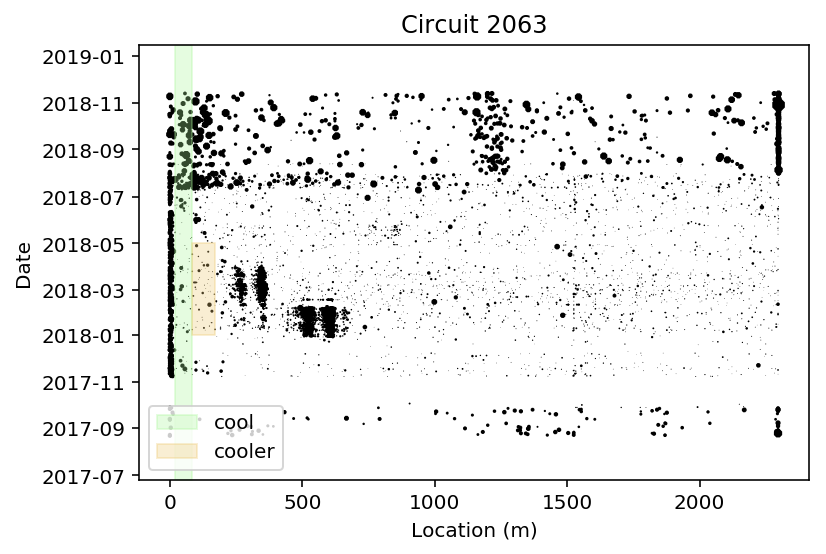

In [72]:
fig, ax = plt.subplots()
clusterizer.plot.draw_location_time_scatter(circuitje, ax=ax)
clusterizer.plot.overlay_rectangle(cool, label="cool")
clusterizer.plot.overlay_rectangle(cooler, label="cooler")
clusterizer.plot.legend_without_duplicate_labels()

Een `Rectangle` houdt ook een lijstje bij met **algoritmes die die rechthoek hebben gevonden**. Hier komen we later op terug.

In [150]:
cool_foundbytwoalgorithms = clusterizer.rectangle.Rectangle(location_range=(20.0, 85.1), found_by=["🐟", "🎯"])
print(cool_foundbytwoalgorithms)

📏 20m to 85m ▒ 	🔍 Found by: 🎯, 🐟


# Nog een submodule: `clusterizer.cluster`
Hierin staat de klasse: `Cluster`.

Een `Cluster` is een **gebied in een locatie-tijd-ruimte**, bestaande uit een verzameling `Rectangle`s. De meest eenvoudige vorm die een `Cluster` kan hebben is dus een enkele rechthoek (het bevat dan een enkele instantie van de klasse `Rectangle`). Zoals de naam al zegt, gebruik je deze klasse om aan te geven waar een cluster zit.

In [151]:
cool_cluster = clusterizer.cluster.Cluster({cool, cooler})
print(cool_cluster)

[📏 85m to 171m ▒ 	⏱ 2018-01-01 until 2018-05-01
📏 20m to 85m]


Je kan van een `Cluster` de begin- en eindlocatie en -tijd krijgen. Dit geeft de buitengrenzen van alle `Rectangle`s die het bevat.

In [152]:
locrange = cool_cluster.location_range
timerange = cool_cluster.time_range

print("[Bounding box] Location range: {0}; time range: {1}".format(locrange, timerange))

[Bounding box] Location range: (20.0, 171.0); time range: None


_Stiekem wordt dan de bounding box berekend:_

In [153]:
cool_cluster.get_bounding_rectangle()

📏 20m to 171m

Merk op dat de bounding box geen begin- en eindtijd heeft, omdat de linkerdriehoek dat niet heeft.

[Bounding box] Location range: (20.0, 171.0); time range: None


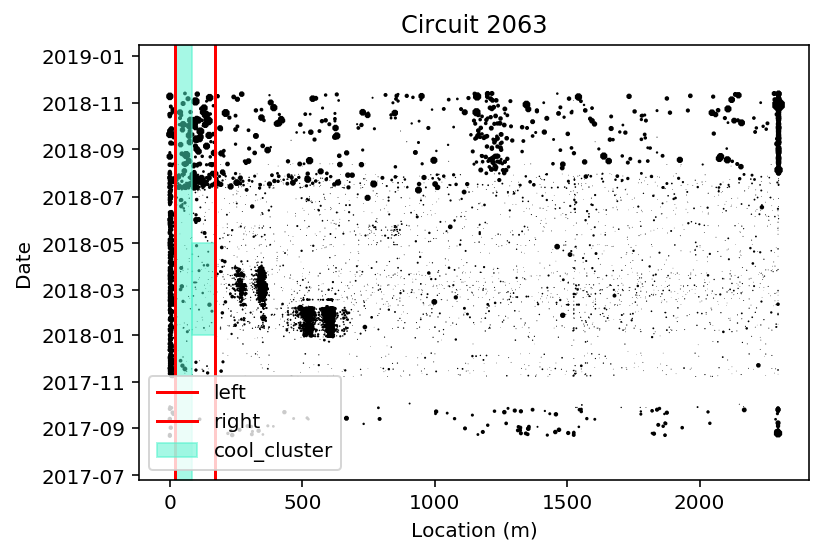

In [154]:
fig, ax = plt.subplots()
clusterizer.plot.draw_location_time_scatter(circuitje, ax=ax)
clusterizer.plot.overlay_cluster(cool_cluster, label="cool_cluster", opacity=.5)

ax.axvline(locrange[0], color="r", label="left")
ax.axvline(locrange[1], color="r", label="right")

print("[Bounding box] Location range: {0}; time range: {1}".format(locrange, timerange))

clusterizer.plot.legend_without_duplicate_labels()

## Combineren van clusters
Een van de sterke punten van deze module is het combineren van verschillende clusters. We komen hier later op terug, nadat we weten hoe we de algoritmes toepassen.

# Belangrijkste submodule: `clusterizer.algorithms`

Alle algoritmes kunnen eenvoudig worden toegepast. Door de standaardparameters aan te passen, en door de resultaten van meerdere algoritmes (of hetzelfde algoritme met andere parameters) te combineren, kan je het resultaat _fine-tunen_.

De output van de algoritmes is een instantie van de klasse `clusterizer.ensemble.ClusterEnsemble`, maar je kan het gebruiken alsof het een Python `set` is (loopen etc).

In [104]:
clusters_poisson = clusterizer.algorithms.clusterize_poisson(circuitje)

print(type(clusters_poisson))
print()
print(clusters_poisson)



<class 'clusterizer.ensemble.ClusterEnsemble'>

{[📏 2292m to 2300m ▒ 	⏱ 2017-08-22 until 2017-10-03 ▒ 	🔍 Found by: Poisson 2D]
[📏 0m to 12m ▒ 	⏱ 2017-11-07 until 2018-05-08 ▒ 	🔍 Found by: Poisson 2D]
[📏 492m to 544m ▒ 	⏱ 2017-12-26 until 2018-02-06 ▒ 	🔍 Found by: Poisson 2D]
[📏 576m to 624m ▒ 	⏱ 2017-12-26 until 2018-02-20 ▒ 	🔍 Found by: Poisson 2D]
[📏 328m to 364m ▒ 	⏱ 2018-02-06 until 2018-04-03 ▒ 	🔍 Found by: Poisson 2D]
[📏 256m to 280m ▒ 	⏱ 2018-02-20 until 2018-03-27 ▒ 	🔍 Found by: Poisson 2D]
[📏 2292m to 2300m ▒ 	⏱ 2018-07-31 until 2018-11-20 ▒ 	🔍 Found by: Poisson 2D]}


Je ziet hierboven één `ClusterEnsemble` (string begint met `{` en eindigt met `}`). Hierin zitten 7 `Cluster`s (string begin met `[` en eindigt met `]`). Omdat dit algoritme simpelweg een rechthoek per cluster vindt, bestaat elke `Cluster` in dit geval uit één `Rectangle`.

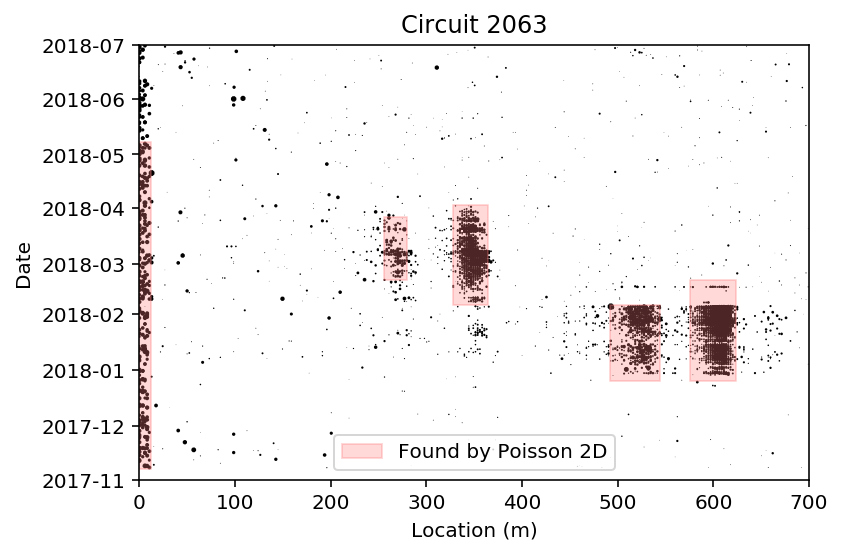

In [105]:
fig, ax = plt.subplots()
clusterizer.plot.draw_location_time_scatter(circuitje, ax=ax)


clusterizer.plot.overlay_cluster_ensemble(clusters_poisson, ax=ax)


ax.set_xlim(0,700)
ax.set_ylim(np.datetime64("2017-11"), np.datetime64("2018-07"))
clusterizer.plot.legend_without_duplicate_labels()

In [116]:
clusters_poisson = clusterizer.algorithms.clusterize_poisson(circuitje)
clusters_DBSCAN = clusterizer.algorithms.clusterize_DBSCAN(circuitje)
clusters_pinta = clusterizer.algorithms.clusterize_pinta(circuitje)

# Ook het Poisson-algoritme, maar met een grotere bakjesgrootte (standaard is dit 4.0).
clusters_poisson_coarse = clusterizer.algorithms.clusterize_poisson(circuitje, loc_bin_size=9.0, name="Poisson 2D coarse")

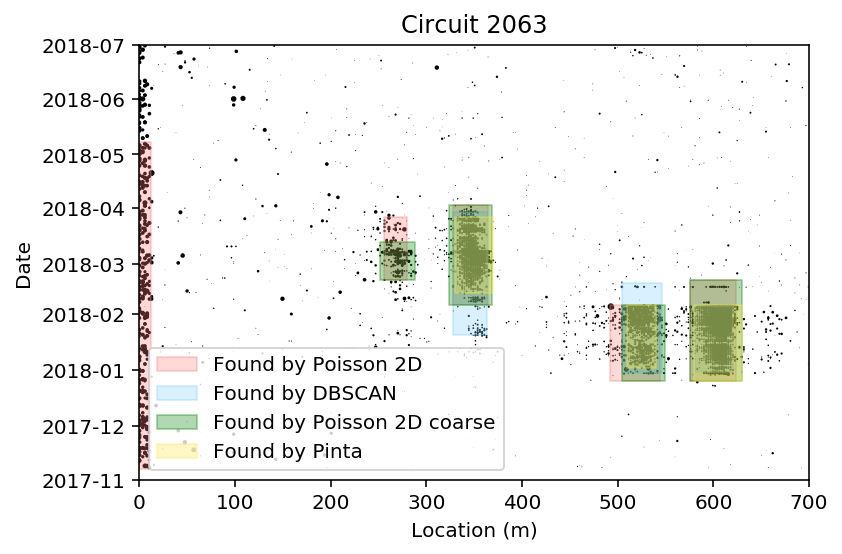

In [119]:
fig, ax = plt.subplots()
clusterizer.plot.draw_location_time_scatter(circuitje, ax=ax)


clusterizer.plot.overlay_cluster_ensemble(clusters_poisson, ax=ax)
clusterizer.plot.overlay_cluster_ensemble(clusters_DBSCAN, ax=ax)
clusterizer.plot.overlay_cluster_ensemble(clusters_poisson_coarse, color="g", ax=ax)
clusterizer.plot.overlay_cluster_ensemble(clusters_pinta, ax=ax)


ax.set_xlim(0,700)
ax.set_ylim(np.datetime64("2017-11"), np.datetime64("2018-07"))
clusterizer.plot.legend_without_duplicate_labels()

## Combineren van `ClusterEnsemble`s

Je kan de resultaten van verschillende algoritmes op handige manieren combineren. Om bijvoorbeeld de overlap van de vier ensembles te krijgen:

In [134]:
found_by_all = clusters_poisson & clusters_DBSCAN & clusters_poisson_coarse & clusters_pinta
found_by_all

{[📏 581m to 620m ▒ 	⏱ 2017-12-30 until 2018-02-05 ▒ 	🔍 Found by: Pinta, Poisson 2D coarse, DBSCAN, Poisson 2D]
[📏 510m to 540m ▒ 	⏱ 2018-01-02 until 2018-02-06 ▒ 	🔍 Found by: Pinta, Poisson 2D coarse, DBSCAN, Poisson 2D]
[📏 330m to 363m ▒ 	⏱ 2018-02-13 until 2018-03-27 ▒ 	🔍 Found by: Pinta, Poisson 2D coarse, DBSCAN, Poisson 2D]}

Of de _vereniging_: dat is per cluster de bounding box van alle rectangles rond dat cluster:

In [135]:
found_by_any = clusters_poisson | clusters_DBSCAN | clusters_poisson_coarse | clusters_pinta
found_by_any

{[📏 2292m to 2300m ▒ 	⏱ 2017-08-22 until 2017-10-03 ▒ 	🔍 Found by: Poisson 2D]
[📏 0m to 12m ▒ 	⏱ 2017-11-07 until 2018-05-08 ▒ 	🔍 Found by: Poisson 2D]
[📏 492m to 549m ▒ 	⏱ 2017-12-26 until 2018-02-18 ▒ 	🔍 Found by: Pinta, Poisson 2D coarse, DBSCAN, Poisson 2D]
[📏 576m to 630m ▒ 	⏱ 2017-12-26 until 2018-02-20 ▒ 	🔍 Found by: Pinta, Poisson 2D coarse, DBSCAN, Poisson 2D]
[📏 324m to 370m ▒ 	⏱ 2018-01-20 until 2018-04-03 ▒ 	🔍 Found by: Pinta, Poisson 2D coarse, DBSCAN, Poisson 2D]
[📏 252m to 288m ▒ 	⏱ 2018-02-20 until 2018-03-27 ▒ 	🔍 Found by: Poisson 2D coarse, Poisson 2D]
[📏 2292m to 2300m ▒ 	⏱ 2018-07-31 until 2018-11-20 ▒ 	🔍 Found by: Poisson 2D]}

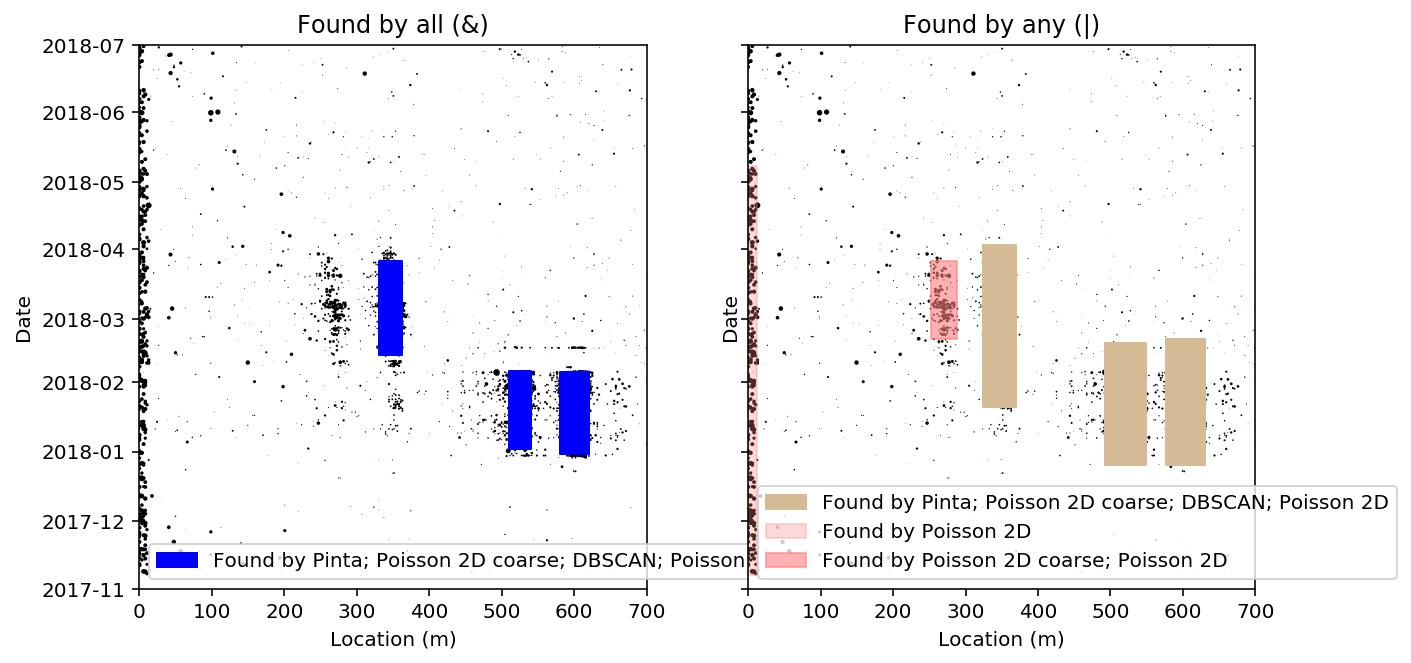

In [146]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharey=True)
clusterizer.plot.draw_location_time_scatter(circuitje, ax=ax[0])
clusterizer.plot.draw_location_time_scatter(circuitje, ax=ax[1])


clusterizer.plot.overlay_cluster_ensemble(found_by_all, color="blue", ax=ax[0])
ax[0].set_title("Found by all (&)")

clusterizer.plot.overlay_cluster_ensemble(found_by_any, ax=ax[1])
ax[1].set_title("Found by any (|)")


ax[0].set_xlim(0,700)
ax[0].set_ylim(np.datetime64("2017-11"), np.datetime64("2018-07"))
clusterizer.plot.legend_without_duplicate_labels(ax[0])
ax[1].set_xlim(0,700)
ax[1].set_ylim(np.datetime64("2017-11"), np.datetime64("2018-07"))
clusterizer.plot.legend_without_duplicate_labels(ax[1])

Je kan ook bijvoorbeeld de vereniging nemen, en dan alle clusters nemen die door minstens 2 algoritmes zijn gevonden:

In [147]:
found_by_at_least_2 = clusterizer.ensemble.ClusterEnsemble(c for c in found_by_any if len(c.found_by) >= 2)
found_by_at_least_2

{[📏 492m to 549m ▒ 	⏱ 2017-12-26 until 2018-02-18 ▒ 	🔍 Found by: Pinta, Poisson 2D coarse, DBSCAN, Poisson 2D]
[📏 576m to 630m ▒ 	⏱ 2017-12-26 until 2018-02-20 ▒ 	🔍 Found by: Pinta, Poisson 2D coarse, DBSCAN, Poisson 2D]
[📏 324m to 370m ▒ 	⏱ 2018-01-20 until 2018-04-03 ▒ 	🔍 Found by: Pinta, Poisson 2D coarse, DBSCAN, Poisson 2D]
[📏 252m to 288m ▒ 	⏱ 2018-02-20 until 2018-03-27 ▒ 	🔍 Found by: Poisson 2D coarse, Poisson 2D]}

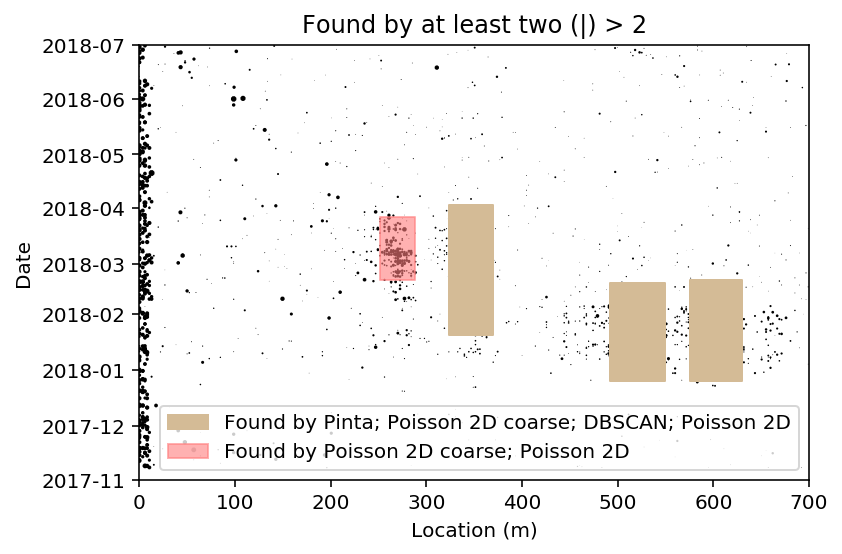

In [148]:
fig, ax = plt.subplots()
clusterizer.plot.draw_location_time_scatter(circuitje, ax=ax)

clusterizer.plot.overlay_cluster_ensemble(found_by_at_least_2, ax=ax)
ax.set_title("Found by at least two (|) > 2")


ax.set_xlim(0,700)
ax.set_ylim(np.datetime64("2017-11"), np.datetime64("2018-07"))
clusterizer.plot.legend_without_duplicate_labels(ax)

# Plaatjes vullen gaatjes: `clusterizer.plot`

Tijdens de ontwikkeling hebben we ook een aantal plotfuncties geschreven. Sommigen hiervan zijn misschien handig, en kunnen worden omgeschreven naar `plotly`.

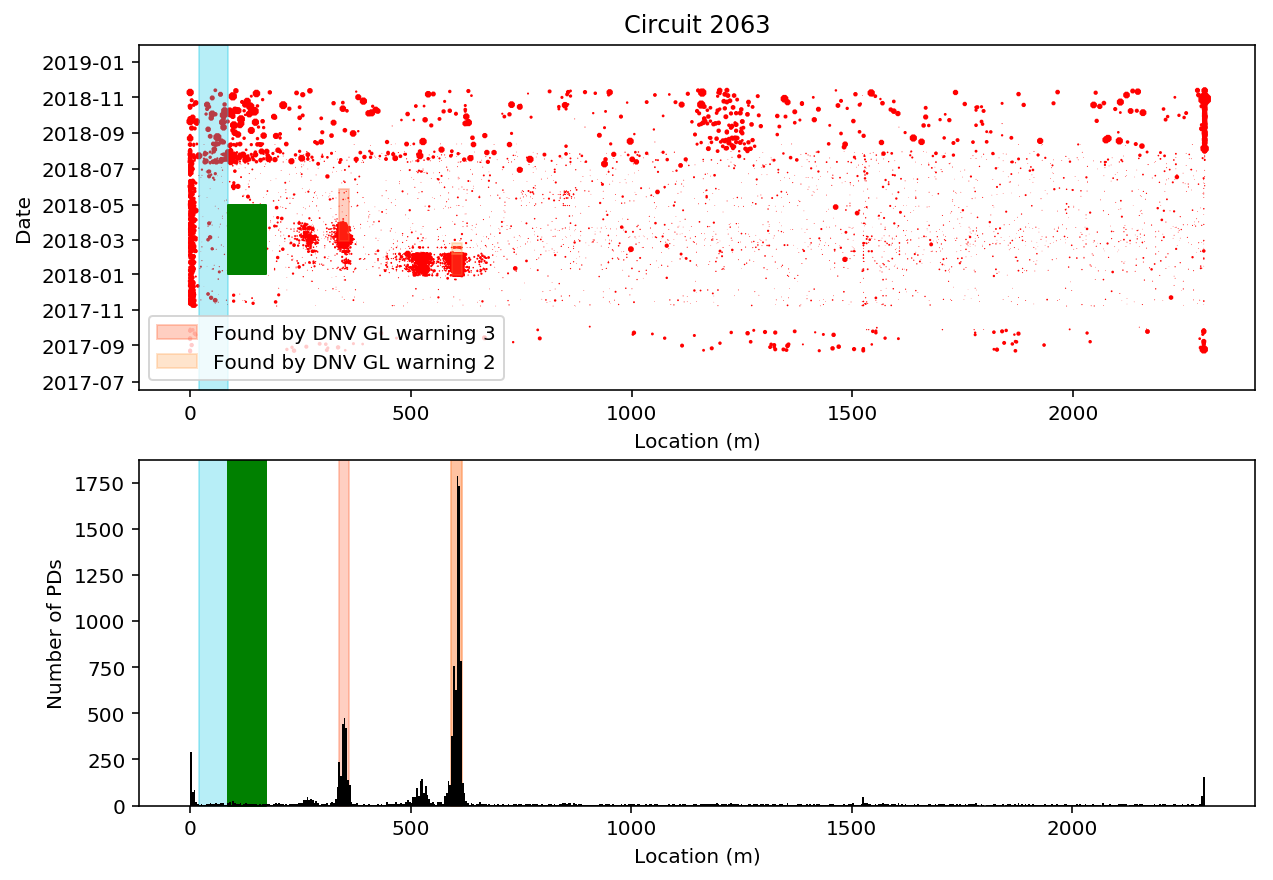

In [130]:
fig, both_axes = plt.subplots(2,1, figsize=(10,7))

clusterizer.plot.draw_location_time_scatter(circuitje, ax=both_axes[0], dot_colors="red")
bakjes_hoogte = clusterizer.plot.draw_location_hist(circuitje, ax=both_axes[1])

clusterizer.plot.overlay_rectangle(cool, ax=both_axes[0])
clusterizer.plot.overlay_rectangle(cool, ax=both_axes[1])
clusterizer.plot.overlay_rectangle(cooler, ax=both_axes[0], color="green", opacity=1)
clusterizer.plot.overlay_rectangle(cooler, ax=both_axes[1], color="green", opacity=1)

clusterizer.plot.overlay_warnings(circuitje, ax=both_axes[0])
clusterizer.plot.overlay_warnings(circuitje, ax=both_axes[1])

both_axes[1].set_title("")

clusterizer.plot.legend_without_duplicate_labels(both_axes[0])